In [1]:
!pip install coronavirus

In [2]:
!apt-get install libgeos
!apt-get install libgeos-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libgeos
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


In [3]:
!pip install https://github.com/matplotlib/basemap/archive/master.zip

  Using cached https://github.com/matplotlib/basemap/archive/master.zip
  Created wheel for basemap: filename=basemap-1.2.1-cp36-cp36m-linux_x86_64.whl size=121756006 sha256=c8b7393776c15b77497a7ce4039575d1681c74e2caf5974b110f3a8d05038958
  Stored in directory: /tmp/pip-ephem-wheel-cache-phx7fg20/wheels/98/4a/fc/ce719b75d97e646645c225f3332b1b217536100314922e9572
Successfully built basemap


In [4]:
!pip install pyproj==1.9.6

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas as pd

%matplotlib inline

import asyncio
import aiohttp

from coronavirus import get_cases

In [0]:
async def getData():
  session = aiohttp.ClientSession()
  cases = await get_cases(session)
  country,confirmed,deaths,recovered,latitude,longitude = [],[],[],[],[],[]
  for case in cases:
    #print(f"Cases in {case.country}: {case.confirmed}")
    #attr of case = id, country, confirmed, deaths, recovered, latitude, longitude, updated
    country.append(case.country)
    confirmed.append(case.confirmed)
    deaths.append(case.deaths)
    recovered.append(case.recovered)
    latitude.append(case.latitude)
    longitude.append(case.longitude)
    await session.close()
  df = pd.DataFrame({"Country":country,"Confirmed":confirmed,"Deaths":deaths,"Recovered":recovered,"Latitude":latitude,"Longitude":longitude})
  return df

In [7]:
  loop = asyncio.get_event_loop()
  dfCovid = loop.run_until_complete(getData())
  dfCovid.head()

,Country,Confirmed,Deaths,Recovered,Latitude,Longitude
0,Canada,1085,12,9,60.0010,-95.0010
1,Maldives,13,0,0,3.2028,73.2207
2,Lithuania,69,0,1,55.1694,23.8813
3,Cambodia,51,0,1,12.5657,104.9910
4,Ethiopia,9,0,0,9.1450,40.4897


In [8]:
dfCovid["Death Rate(%)"] = round((dfCovid["Deaths"]/dfCovid["Confirmed"])*100,2)
dfCovid["Not Recovered"] = dfCovid["Confirmed"] - dfCovid["Recovered"] - dfCovid["Deaths"]
dfCovid.head(3)

,Country,Confirmed,Deaths,Recovered,Latitude,Longitude,Death Rate(%),Not Recovered
0,Canada,1085,12,9,60.0010,-95.0010,1.11,1064
1,Maldives,13,0,0,3.2028,73.2207,0.00,13
2,Lithuania,69,0,1,55.1694,23.8813,0.00,68


In [9]:
df_sort_confirmed = dfCovid.sort_values(["Confirmed"],ascending=False)
df_sort_confirmed = df_sort_confirmed.reset_index(drop=True)
df_sort_confirmed.head(3)

,Country,Confirmed,Deaths,Recovered,Latitude,Longitude,Death Rate(%),Not Recovered
0,China,81304,3259,71857,30.5928,114.3055,4.01,6188
1,Italy,47021,4032,4440,41.8719,12.5674,8.57,38549
2,Spain,25374,1375,2125,40.4637,-3.7492,5.42,21874


In [10]:
df_sort_deathrate = dfCovid.sort_values(["Death Rate(%)"],ascending=False)
df_sort_deathrate = df_sort_deathrate.reset_index(drop=True)
df_sort_deathrate.head(3)

,Country,Confirmed,Deaths,Recovered,Latitude,Longitude,Death Rate(%),Not Recovered
0,Sudan,2,1,0,12.8628,30.2176,50.00,1
1,Gabon,4,1,0,-0.8037,11.6094,25.00,3
2,Guyana,7,1,0,4.8604,-58.9302,14.29,6


**Melakukan plotting terhadap persebaran COVID-19**

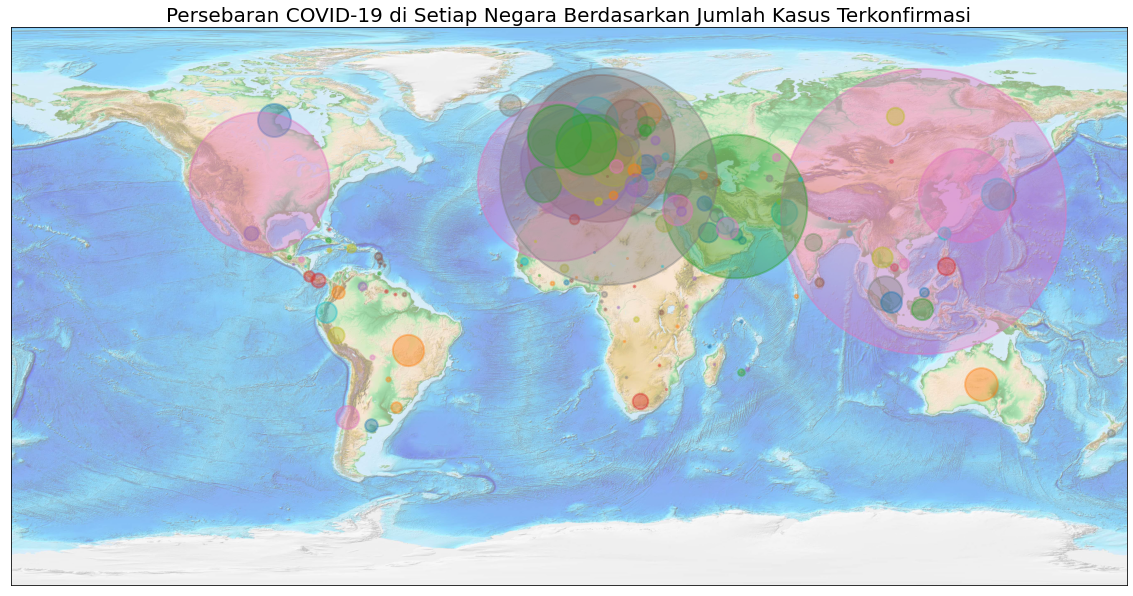

In [11]:
fig = plt.figure(figsize=(20, 20))
m = Basemap(projection='cyl', resolution="h",
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )
m.etopo(scale=0.5, alpha=0.5)
plt.title("Persebaran COVID-19 di Setiap Negara Berdasarkan Jumlah Kasus Terkonfirmasi", fontsize='20')
for i in range(int(dfCovid.shape[0])):
  x, y = m(dfCovid.iloc[i:i+1]["Longitude"].values[0], dfCovid.iloc[i:i+1,:]["Latitude"])
  plt.scatter(x, y, s=dfCovid.iloc[i:i+1,:]["Confirmed"].values[0], cmap="Blues", alpha=0.4, linewidth=2)
  #plt.plot(x, y, 'ok', markersize=2)
  #plt.text(x, y, dfCovid.iloc[i:i+1,:]["Country"].values[0], fontsize=7);

**Melakukan plotting terhadap penderita COVID-19 pada sepuluh negara dengan kasus terkonfirmasi terbanyak**

In [12]:
top_ten_confirmed = df_sort_confirmed.iloc[0:10,:].copy()
top_ten_confirmed = top_ten_confirmed.set_index("Country")
top_ten_confirmed.head() 

,Confirmed,Deaths,Recovered,Latitude,Longitude,Death Rate(%),Not Recovered
Country,,,,,,,
China,81304,3259,71857,30.5928,114.3055,4.01,6188
Italy,47021,4032,4440,41.8719,12.5674,8.57,38549
Spain,25374,1375,2125,40.4637,-3.7492,5.42,21874
Germany,21652,73,209,51.1657,10.4515,0.34,21370
Iran,20610,1556,7635,32.4279,53.6880,7.55,11419


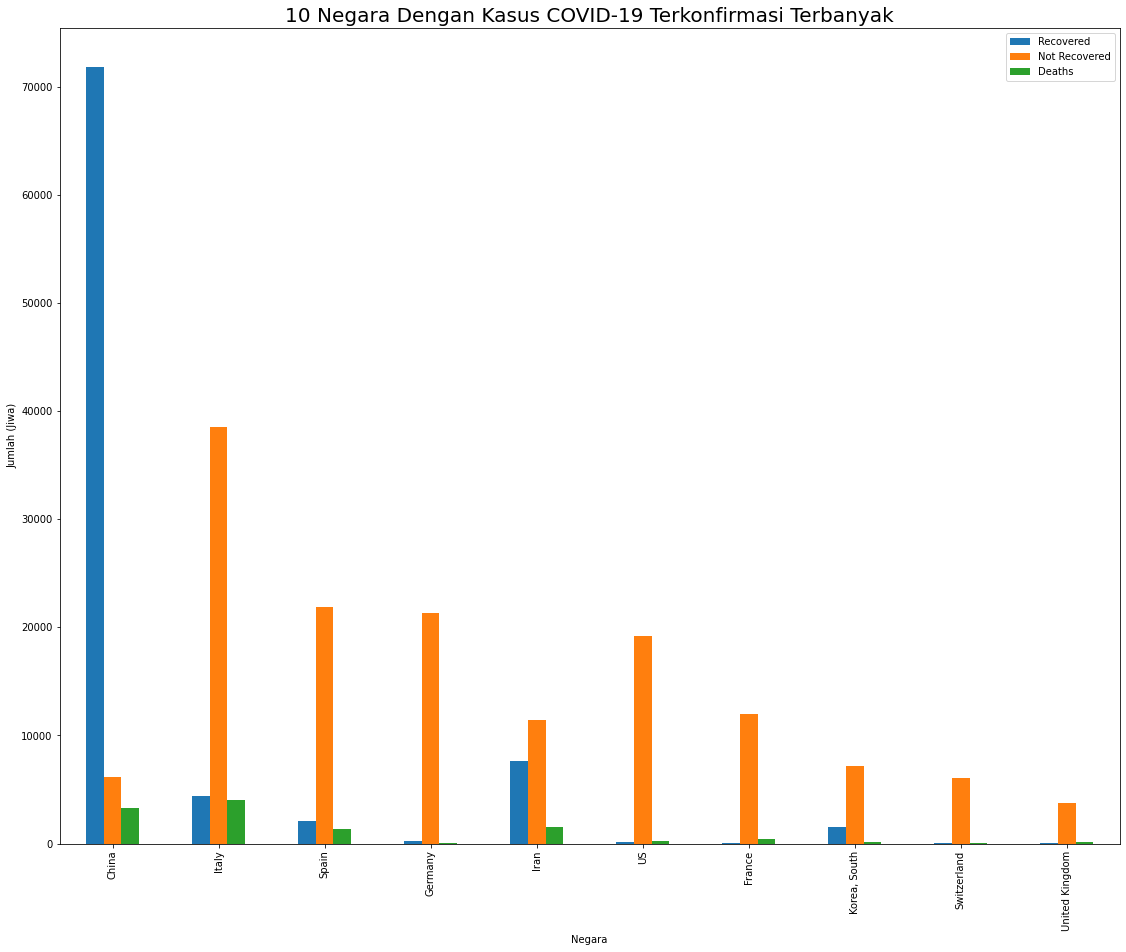

In [13]:
top_ten_confirmed[["Recovered","Not Recovered","Deaths"]].plot.bar(stacked=False)
plt.gcf().set_size_inches(19, 15)
plt.title("10 Negara Dengan Kasus COVID-19 Terkonfirmasi Terbanyak", fontsize = 20)
plt.xlabel("Negara")
plt.ylabel("Jumlah (Jiwa)")
plt.show()

**Melakukan plotting terhadap 10 negara dengan tingkat kematian tertinggi (kasus terkonfirmasi > 1000)**

In [14]:
top_ten_deathrate_thousand = dfCovid[dfCovid["Confirmed"]>1000]
top_ten_deathrate_thousand = top_ten_deathrate_thousand.sort_values(["Death Rate(%)"], ascending=False)
top_ten_deathrate_thousand = top_ten_deathrate_thousand.iloc[0:10,:].copy()
top_ten_deathrate_thousand = top_ten_deathrate_thousand.set_index("Country")
top_ten_deathrate_thousand.head() 

,Confirmed,Deaths,Recovered,Latitude,Longitude,Death Rate(%),Not Recovered
Country,,,,,,,
Italy,47021,4032,4440,41.8719,12.5674,8.57,38549
Iran,20610,1556,7635,32.4279,53.6880,7.55,11419
Spain,25374,1375,2125,40.4637,-3.7492,5.42,21874
United Kingdom,4014,178,67,55.0000,-3.0000,4.43,3769
China,81304,3259,71857,30.5928,114.3055,4.01,6188


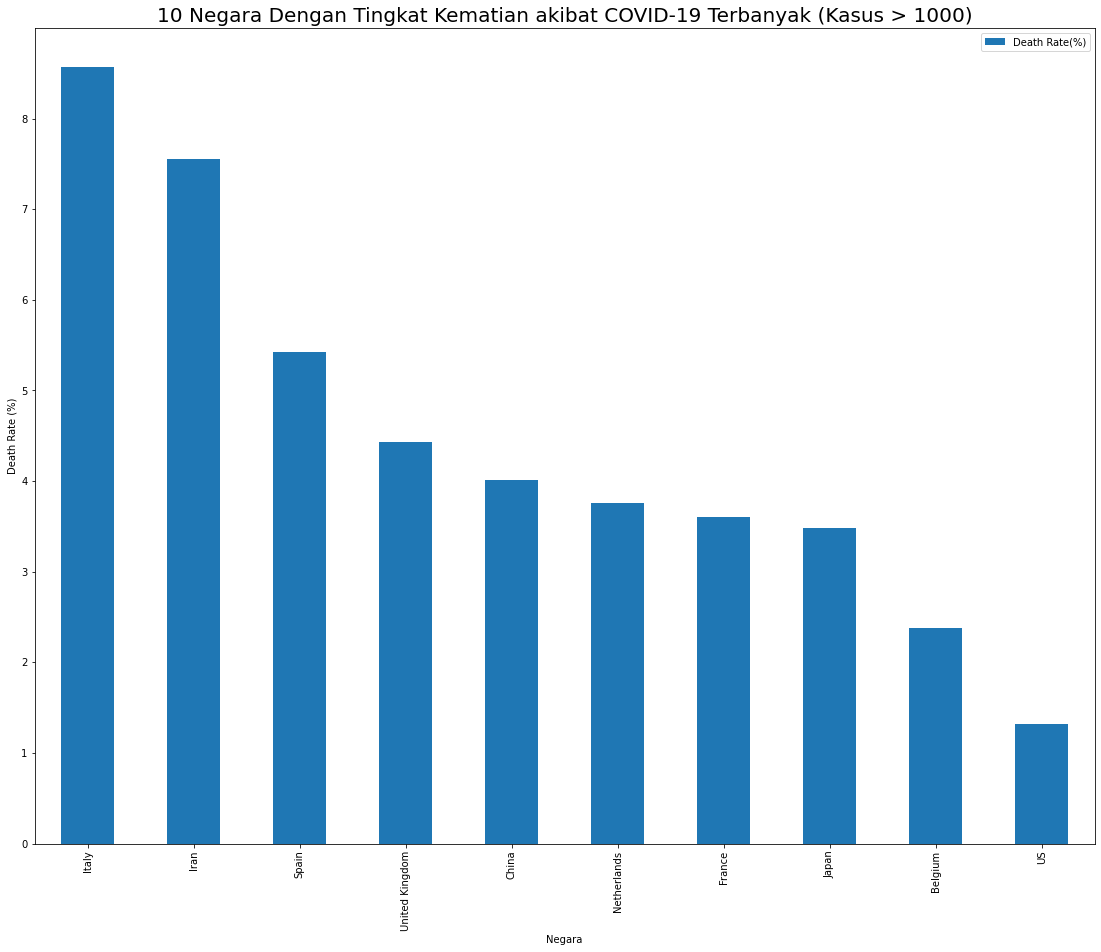

In [15]:
top_ten_deathrate_thousand[["Death Rate(%)"]].plot.bar()
plt.gcf().set_size_inches(19, 15)
plt.title("10 Negara Dengan Tingkat Kematian akibat COVID-19 Terbanyak (Kasus > 1000)", fontsize = 20)
plt.xlabel("Negara")
plt.ylabel("Death Rate (%)")
plt.show()